# MRI - Alzheimer Stage Classifier
### by Haim Elbaz & Asaf Levi


## Introduction
The goal of this project is to provide a tool to classify MRI images of alzheimer patients into the different stages of the disease, characterized by dementia severity levels. 

To accomplish this, We will build a CNN model using PyTorch and train it with data obtained from kaggle:

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images

## Dataset
### Data Description

### Data Praparation & Preprocessing

The dataset is already split into a train & test sub-sets. 
Within the directories of these sets, the images are arranged in subdirectories named after the class. The image file name indicates an image's unique ID. 

PyTorch's ImageFolder dataset subclass fits exactly this arrangement. 

In [10]:
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt

from helper import show_images
from torchsummary import summary


In [11]:
TRAINPATH = "Alzheimer_s Dataset/train/"
TESTPATH  = "Alzheimer_s Dataset/train/"

# Making code compatible with either M1, Cuda or CPU
# device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
device = "cpu"
print(f"Chosen device: {device}")

Chosen device: cpu


In [12]:
transformer = transforms.Compose([transforms.Resize((208, 176)),
                                transforms.CenterCrop((188, 156)),
                                transforms.Grayscale(num_output_channels=1),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAINPATH, transform=transformer)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

We would like to keep the test set for testing purposes. Therefore, we will split the training dataset into training and validation datasets, so that 20% of training data will be used for validation.

In [13]:
total_train_size = len(train_dataset)
print(f"Total train size: {total_train_size}")

validation_set_size = int(total_train_size * 0.2)
print(f"Validation set size: {validation_set_size}")

training_set_size = total_train_size - validation_set_size
print(f"Training set size: {training_set_size}")

training_set, validation_set = torch.utils.data.random_split(train_dataset, [training_set_size, validation_set_size])

assert validation_set_size == len(validation_set), "Validation size mismatch"
assert training_set_size == len(training_set), "Training size mismatch"
assert training_set_size + validation_set_size == total_train_size, "Dataset size mismatch after split"


Total train size: 5121
Validation set size: 1024
Training set size: 4097


In [14]:
train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

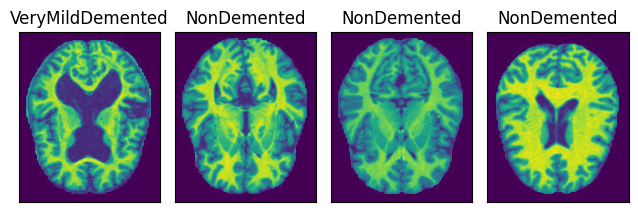

In [15]:
img, labels = next(iter(train_loader))
show_images([img[i] for i in range(4)], labels, idx_to_class)

## Methods

### Pooling layer ideas
https://link.springer.com/article/10.1007/s00521-022-06953-8

"Pooling in convolutional neural networks for medical image analysis: a survey and an empirical study"


### Medical image analysis
https://link.springer.com/article/10.1007/s10916-018-1088-1


https://rdcu.be/dgvzI

"Medical Image Analysis using Convolutional Neural Networks: A Review"




### MRI Specific
https://www.sciencedirect.com/science/article/pii/S0933365716305206?casa_token=5tByST2VQV0AAAAA:0xn4a1oH7qP7xLVQ8qK9Py7pzZ8s_cDKEW2PuOQVENX_krGGj4xc2DUTQdk_FVsr9bfXYiXJJbC9


"Deep convolutional neural networks for brain image analysis on magnetic resonance imaging: a review"






In [16]:
def train_model(model: nn.Module, loss_function, optimizer, n_epochs: int, model_filename: str):
    epochs = range(n_epochs)
    train_loss_curve = list()
    validation_loss_curve = list()

    for epoch in range(n_epochs):
        epoch_train_loss = 0.0
        epoch_validation_loss = 0.0
        
        accuracy = 0
        count = 0
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            y_pred = model(inputs)
            train_loss = loss_function(y_pred, labels)
            train_loss.backward()
            optimizer.step()    
            epoch_train_loss += train_loss.item() * inputs.size(0) 
            
            y_pred = model(inputs)
        accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
            
            
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_pred = model(inputs)
            validation_loss = loss_function(y_pred, labels)
            epoch_validation_loss += validation_loss.item() * inputs.size(0) 
        
        train_loss_curve.append(epoch_train_loss / len(train_loader.sampler))
        validation_loss_curve.append(epoch_validation_loss / len(validation_loader.sampler))
        
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            y_pred = model(inputs)
            accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
            count += len(labels)
        
        accuracy /= count
        
        print("Epoch %d: model accuracy %.2f%%" % (epoch, accuracy * 100))
        print(f"Epoch {epoch}: avg. loss {train_loss_curve[-1]}")
        torch.save(model.state_dict(), model_filename)
        
        return model, train_loss_curve, validation_loss_curve
    
    
def plot_loss_curve(train_loss_curve, validation_loss_curve):
    plt.plot(range(len(train_loss_curve)), train_loss_curve, label='Training Loss')
    plt.plot(range(len(validation_loss_curve)), validation_loss_curve, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()


### LeNet
Due to its simplicity, we will start with a modified LeNet5 which is proved useful for classification problems, but also specifically proved useful in Alzheimer classification from MRI images.

#### Modifications
* Adjusted output layer for 4 classes
* Our loss function is Cross Entropy Loss, which has softmax activation implemented inside of it in PyTorch, so the last activation function is 'removed' from the net definition. Adding that layer in the net results in an error.
* Dimensions, input/output sizes are adjusted for slightly smaller numbers.

In [19]:
class LeNet5(nn.Module):
    def __init__(self):
      super(LeNet5, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 5, 1, padding=1)
      self.tanh1 = nn.Tanh()
      self.avgpool1 = nn.AvgPool2d(2, stride=2)
      
      self.conv2 = nn.Conv2d(6, 16, 5, 1, padding=1)
      self.tanh2 = nn.Tanh()
      self.avgpool2 = nn.AvgPool2d(2, stride=2)
      
      self.conv3 = nn.Conv2d(16, 1, 5, 1, padding=1)
      self.tanh3 = nn.Tanh()
      
      self.flat1 = nn.Flatten()
      self.fc1 = nn.Linear(1505, 150)
      self.tanh4 = nn.Tanh()
      self.flat2 = nn.Flatten()
      self.fc2 = nn.Linear(150, 4)
      
      
      
      
    # Spatial transformer localization-network
      self.localization = nn.Sequential(
          nn.Conv2d(1, 8, kernel_size=7),
          nn.MaxPool2d(2, stride=2),
          nn.ReLU(True),
          nn.Conv2d(8, 20, kernel_size=5),
          nn.MaxPool2d(2, stride=2),
          nn.ReLU(True)
        )

        
    def forward(self, x):
      x = self.conv1(x)
      x = self.tanh1(x)
      x = self.avgpool1(x)
      
      x = self.conv2(x)
      x = self.tanh2(x)
      x = self.avgpool2(x)
      
      x = self.conv3(x)
      x = self.tanh3(x)
      
      x = self.flat1(x)
      x = self.fc1(x)
      x = self.tanh4(x)
      x = self.flat2(x)
      x = self.fc2(x)
      
      return x
    
    
summary(LeNet5(), input_size=(1, 188, 156))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 186, 154]             156
              Tanh-2          [-1, 6, 186, 154]               0
         AvgPool2d-3            [-1, 6, 93, 77]               0
            Conv2d-4           [-1, 16, 91, 75]           2,416
              Tanh-5           [-1, 16, 91, 75]               0
         AvgPool2d-6           [-1, 16, 45, 37]               0
            Conv2d-7            [-1, 1, 43, 35]             401
              Tanh-8            [-1, 1, 43, 35]               0
           Flatten-9                 [-1, 1505]               0
           Linear-10                  [-1, 150]         225,900
             Tanh-11                  [-1, 150]               0
          Flatten-12                  [-1, 150]               0
           Linear-13                    [-1, 4]             604
Total params: 229,477
Trainable params:

Cross Entropy Loss is a good loss function for classification tasks, as it heavily penalizes false predictions that the model was very confident in. 

In [ ]:
MRI_Alzh_LeNet5 = LeNet5().to(device)
model_results = train_model(MRI_Alzh_LeNet5,    
                            loss_function=nn.CrossEntropyLoss(),
                            optimizer = torch.optim.SGD(MRI_Alzh_LeNet5.parameters(), 
                            lr=0.01, momentum=0.9),
                            n_epochs=1, 
                            model_filename="MRI_Alzh_LeNet5.pth")
trained_lenet5, train_loss_curve, validation_loss_curve = model_results

In [ ]:
plot_loss_curve(train_loss_curve, validation_loss_curve)

In [ ]:
class STNLeNet5(nn.Module):
    def __init__(self):
      super(STNLeNet5, self).__init__()
      self.conv1 = nn.Conv2d(1, 6, 5, 1, padding=1)
      self.tanh1 = nn.Tanh()
      self.avgpool1 = nn.AvgPool2d(2, stride=2)
      
      self.conv2 = nn.Conv2d(6, 16, 5, 1, padding=1)
      self.tanh2 = nn.Tanh()
      self.avgpool2 = nn.AvgPool2d(2, stride=2)
      
      self.conv3 = nn.Conv2d(16, 1, 5, 1, padding=1)
      self.tanh3 = nn.Tanh()
      
      self.flat1 = nn.Flatten()
      self.fc1 = nn.Linear(1505, 150)
      self.tanh4 = nn.Tanh()
      self.flat2 = nn.Flatten()
      self.fc2 = nn.Linear(150, 4)
      
      
      
      
    # Spatial transformer localization-network
      self.localization = nn.Sequential(
          nn.Conv2d(1, 8, kernel_size=7),
          nn.MaxPool2d(2, stride=2),
          nn.ReLU(True),
          nn.Conv2d(8, 20, kernel_size=5),
          nn.MaxPool2d(2, stride=2),
          nn.ReLU(True)
        )

      # Regressor for the 3 * 2 affine matrix
      self.fc_loc = nn.Sequential(
          nn.Linear(30100, 32),
          nn.ReLU(True),
          nn.Linear(32, 3 * 2)
      )

      # Initialize the weights/bias with identity transformation
      self.fc_loc[2].weight.data.zero_()
      self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 30100)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)
        

        return x

      
        
    def forward(self, x):
      x = self.stn(x)
      x = self.conv1(x)
      x = self.tanh1(x)
      x = self.avgpool1(x)
      
      x = self.conv2(x)
      x = self.tanh2(x)
      x = self.avgpool2(x)
      
      x = self.conv3(x)
      x = self.tanh3(x)
      
      x = self.flat1(x)
      x = self.fc1(x)
      x = self.tanh4(x)
      x = self.flat2(x)
      x = self.fc2(x)
      
      return x

In [ ]:
MRI_Alzh_STNLeNet5 = STNLeNet5().to(device)
model_results = train_model(MRI_Alzh_LeNet5,    
                            loss_function=nn.CrossEntropyLoss(),
                            optimizer = torch.optim.SGD(MRI_Alzh_LeNet5.parameters(), 
                            lr=0.01, momentum=0.9),
                            n_epochs=1, 
                            model_filename="MRI_Alzh_LeNet5.pth")
trained_lenet5, train_loss_curve, validation_loss_curve = model_results

In [ ]:
plot_loss_curve(train_loss_curve, validation_loss_curve)